In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# print(tf.__version__)

import os
import logging
import pandas as pd
import seaborn as sns
from datetime import datetime, date 
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import pickle
logging.basicConfig(filename="temp.log", filemode = "w", level=logging.INFO) # add filemode="w" to overwrite
from dataPull import getYfinData as getYfinData

""" References
https://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide

"""

' References\nhttps://www.kaggle.com/andreshg/timeseries-analysis-a-complete-guide\n\n'

In [4]:
# API Key 9ade9b4338e22712d55169be6f5a2b65
# FRED ST Louse
# https://fred.stlouisfed.org/docs/api/fred/

$\hat{Y} = \hat{\beta}_{0} + \sum \limits _{j=1} ^{p} X_{j}\hat{\beta}_{j} $
https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214

## Function Definition

In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

## Data Pull

In [6]:
# Data Pull
dataPullCfg = True
vpnFlg = True

myTicker = 'NVDA'
tickerLst = ['XPO', 'BABA', 'NVDA', 'QQQ', 'ENPH']
# requestThd = 5
dateFilt = '2021-8-15'
# getData(tickerLst, requestThd, dateFilt) # Alpha Vantage

if not vpnFlg:
    os.environ['http_proxy'] = ''
    os.environ['https_proxy'] = ''
else:
    print('Enter at a later time!')

if dataPullCfg:
    getYfinData(tickerLst, None)

# -------------------------------------------------------------------- #
# Load Data from Disk
dir = os.getcwd()
dir = dir + "\\" + "stockData.file"
with open(dir, "rb") as f:
    dump = pickle.load(f)
    print("deserialization of " + dir + " complete...")
assert len(dump) > 0, 'Check Data Pull'

Enter at a later time!
deserialization of c:\Users\malikf1\Desktop\DataScience\Local_Development\Personal_Projects\MLStockForecast\stockData.file complete...


## Data Wrangle

In [7]:
stockDataFrame = dump[myTicker].copy(deep=True)

In [8]:
stockDataFrame.describe()

,open,high,low,close,volume,dividends,stock_splits
count,5786.000000,5786.000000,5786.000000,5786.000000,5.786000e+03,5786.000000,5786.000000
mean,22.236630,22.612284,21.826181,22.233823,6.180257e+07,0.000203,0.001642
std,47.349225,48.175047,46.393747,47.308698,4.509453e+07,0.002620,0.067342
min,0.320556,0.326538,0.306203,0.313380,1.968000e+06,0.000000,0.000000
25%,2.349155,2.428002,2.281408,2.348724,3.362970e+07,0.000000,0.000000
50%,3.687073,3.746906,3.630480,3.687477,5.151540e+07,0.000000,0.000000
75%,8.880678,8.989219,8.767845,8.876387,7.593730e+07,0.000000,0.000000
max,335.128979,346.427583,320.320763,333.719147,9.230856e+08,0.040000,4.000000


In [9]:
stockDataFrame.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})

,date,open,high,low,close,volume,dividends,stock_splits,symbol,load_date
0,1999-01-22 00:00:00,0.401892,0.448540,0.356440,0.376774,271468800.000000,0.000000,0.000000,NVDA,2022-01-18
1,1999-01-25 00:00:00,0.406676,0.421029,0.376774,0.416245,51048000.000000,0.000000,0.000000,NVDA,2022-01-18
2,1999-01-26 00:00:00,0.421029,0.429403,0.377970,0.383951,34320000.000000,0.000000,0.000000,NVDA,2022-01-18
3,1999-01-27 00:00:00,0.385147,0.394716,0.363616,0.382755,24436800.000000,0.000000,0.000000,NVDA,2022-01-18
4,1999-01-28 00:00:00,0.382755,0.385147,0.379166,0.381559,22752000.000000,0.000000,0.000000,NVDA,2022-01-18


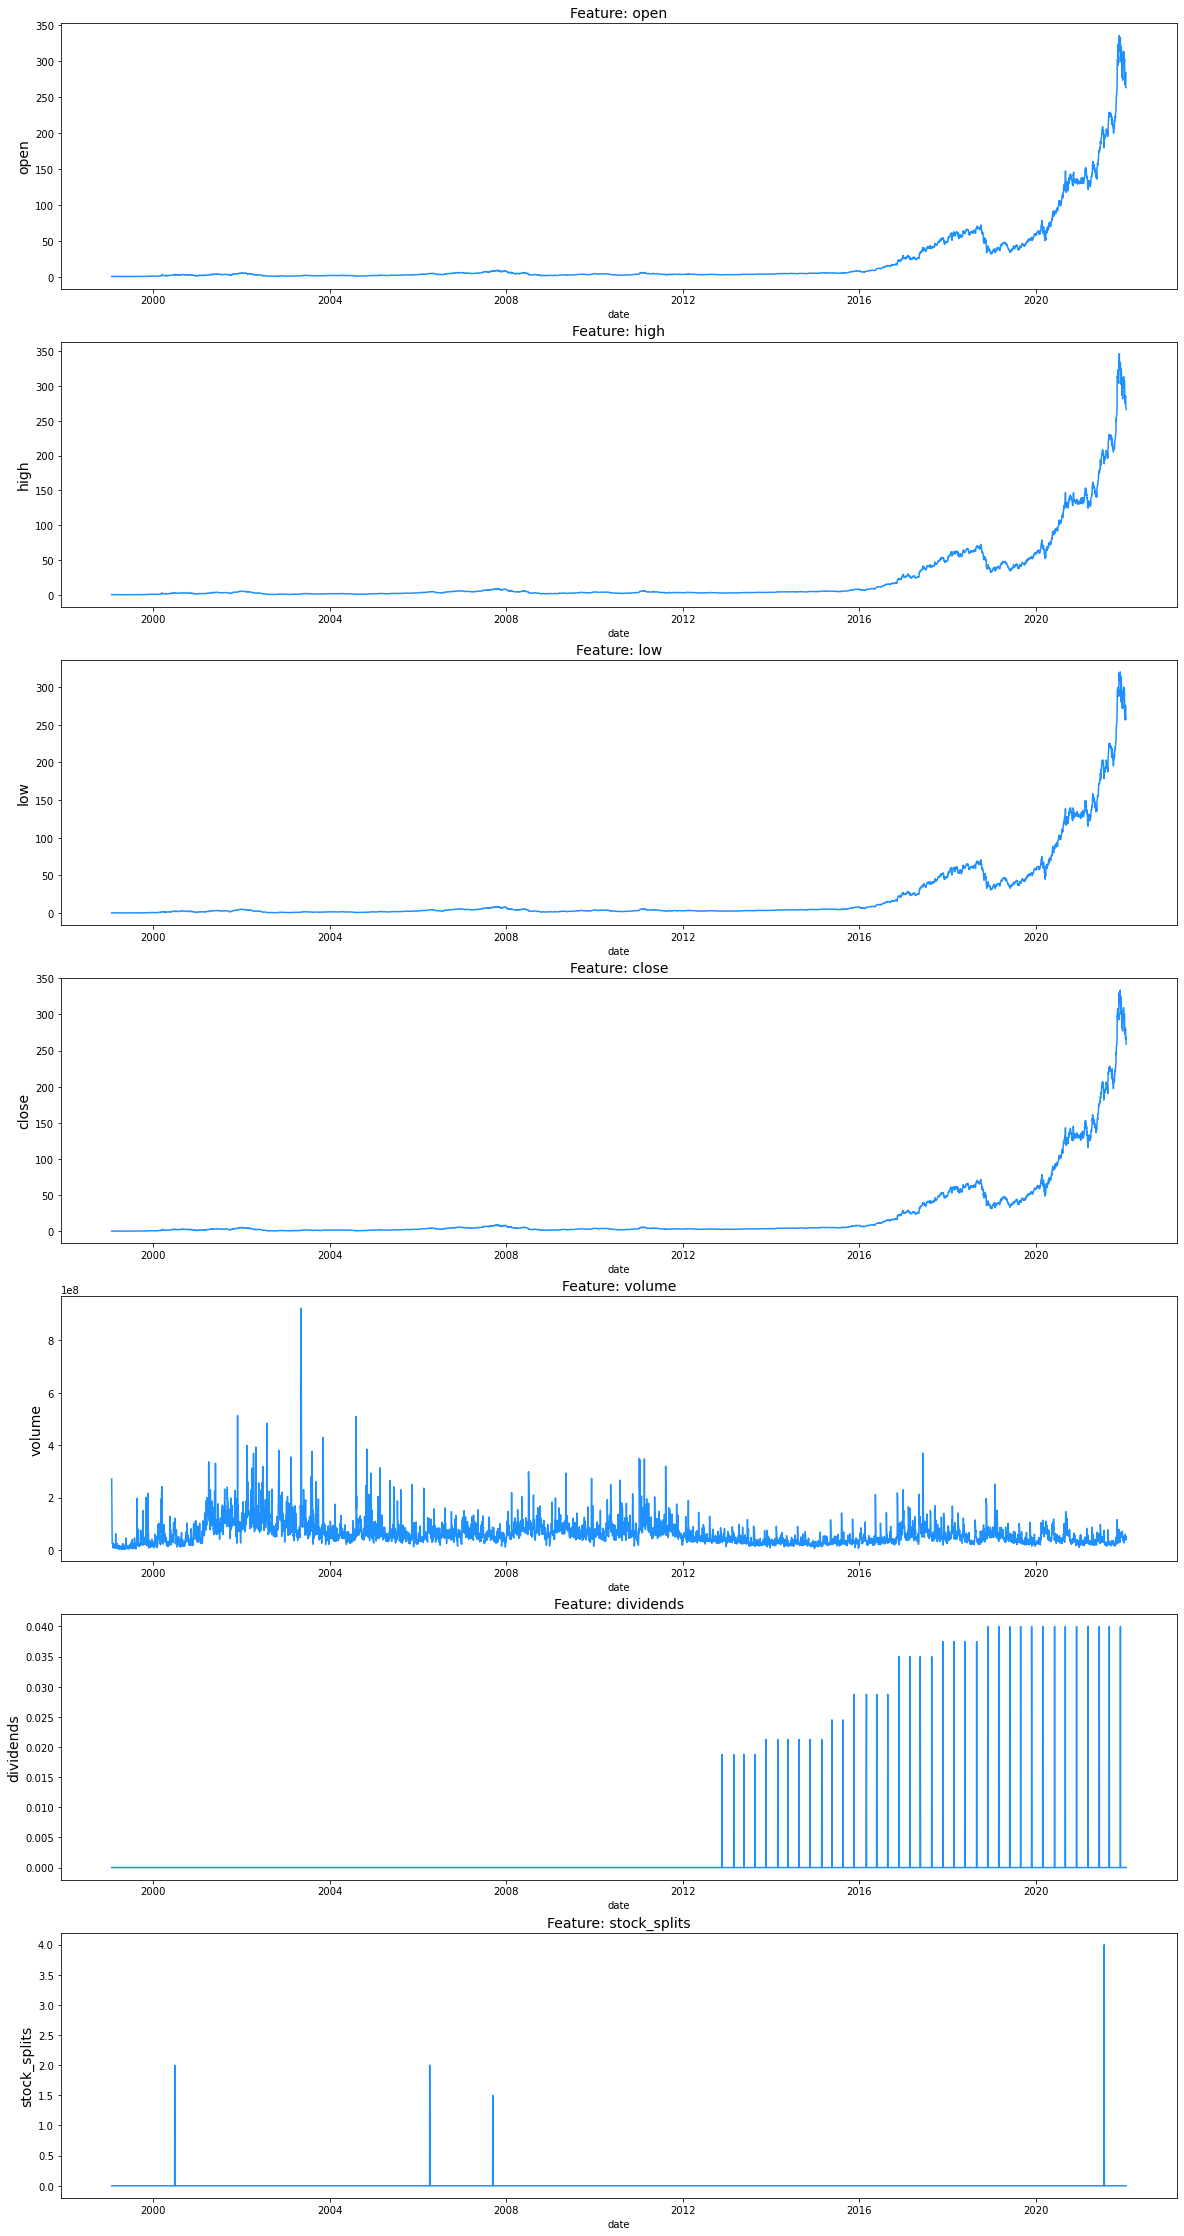

In [10]:
# To complete the data, as naive method, we will use ffill
f, ax = plt.subplots(nrows=7, ncols=1, figsize=(20, 40))

for i, column in enumerate(stockDataFrame.drop(['date', 'load_date', 'symbol'], axis=1).columns):
    sns.lineplot(x=stockDataFrame['date'], y=stockDataFrame[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    #ax[i].set_xlim([date(2020, 1, 1), date(2022, 1, 10)])    

In [11]:
# Chronological Order and Equidistant Timestamps
stockDataFrame['delta'] = stockDataFrame['date'] - stockDataFrame['date'].shift(1)
stockDataFrame['delta'].sum(), stockDataFrame['delta'].count()
stockDataFrame = stockDataFrame.drop('delta', axis=1)
stockDataFrame.isna().sum()


date            0
open            0
high            0
low             0
close           0
volume          0
dividends       0
stock_splits    0
symbol          0
load_date       0
dtype: int64

## Smothing Data/Resampling

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\mali

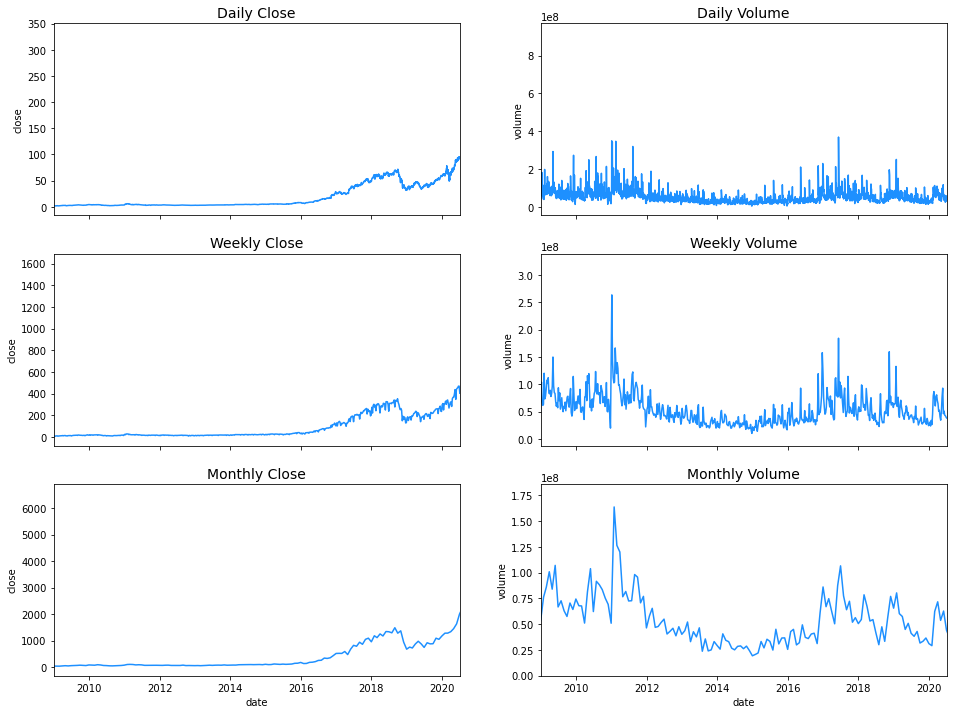

In [12]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16,12))

sns.lineplot(stockDataFrame['date'], stockDataFrame['close'], color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Daily Close', fontsize=14)

resampled_df = stockDataFrame[['date','close']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['close'], color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Close', fontsize=14)

resampled_df = stockDataFrame[['date','close']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['close'], color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Close', fontsize=14)

for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(stockDataFrame['date'], stockDataFrame['volume'], color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Volume', fontsize=14)

resampled_df = stockDataFrame[['date','volume']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['volume'], color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Volume', fontsize=14)

resampled_df = stockDataFrame[['date','volume']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(resampled_df['date'], resampled_df['volume'], color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Volume', fontsize=14)

# for i in range(3):
#     ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

In [13]:
# As we can see, downsample to monthly could smooth the data and help with analysis
downsample = stockDataFrame[['date',
                 'open', 
                 'high',
                 'low', 
                 'close',
                 'volume',
                 'dividends',
                 'stock_splits',
                 'symbol',
                 'load_date'
                ]].resample('M', on='date').mean().reset_index(drop=False)

df = downsample.copy()

In [14]:
df

,date,open,high,low,close,volume,dividends,stock_splits
0,1999-01-31,0.396510,0.410265,0.369597,0.384150,7.140480e+07,0.000000,0.0
1,1999-02-28,0.390812,0.404725,0.372619,0.387287,1.656101e+07,0.000000,0.0
2,1999-03-31,0.401008,0.410681,0.386603,0.397004,8.758748e+06,0.000000,0.0
3,1999-04-30,0.369768,0.377514,0.357010,0.365553,8.414400e+06,0.000000,0.0
4,1999-05-31,0.344479,0.352014,0.332697,0.341758,1.241256e+07,0.000000,0.0
...,...,...,...,...,...,...,...,...
272,2021-09-30,219.904501,221.920924,216.692038,219.338858,2.380264e+07,0.000000,0.0
273,2021-10-31,219.735476,223.496444,217.488134,221.077217,2.366800e+07,0.000000,0.0
274,2021-11-30,303.681383,311.570893,296.050888,303.848030,5.147493e+07,0.000000,0.0
275,2021-12-31,301.231361,307.395454,291.957271,299.307272,5.026108e+07,0.001818,0.0


## Stationariy
Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has
- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

![title](img/stationarity.png)

The check for stationarity can be done via three different approaches:
1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test


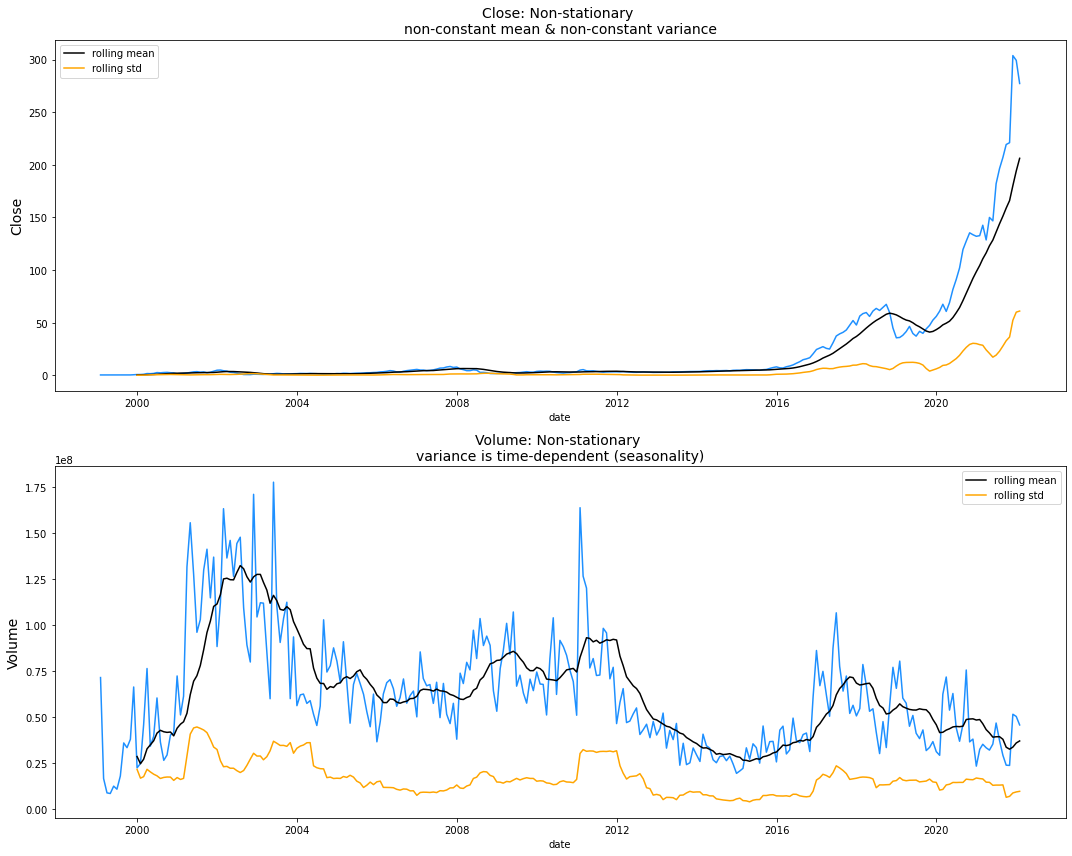

In [15]:
# A year has 12 months. Use 12 instead of 52           ||52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 12
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['close'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['close'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['close'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Close: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Close', fontsize=14)
#ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['volume'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['volume'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['volume'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Volume: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)
#ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In this visual check, we can see that the **features don't have constant mean and std**.

## Augmented Dickey-Fuller (ADF)
**Augmented Dickey-Fuller (ADF)** test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.
- **Null Hypothesis (H0)**: Time series has a unit root. (Time series is not stationary).
- **Alternate Hypothesis (H1)**: Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%
- **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

- **ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- **ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.



In [16]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['close'].values)
result

(3.2346096745322757,
 1.0,
 14,
 262,
 {'1%': -3.455558114028747,
  '5%': -2.872635586277424,
  '10%': -2.572682677000175},
 1615.470470715585)

In [17]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1]) # p-val > 0.5, this is non-stationary

ADF Statistic: 3.234610
p-value: 1.000000


Now, we are going to check for each variable:

The p-value is greater than 0.05. This indicates that the data is non-stationary.
Check the range of the ADF statistic compared with critical_values

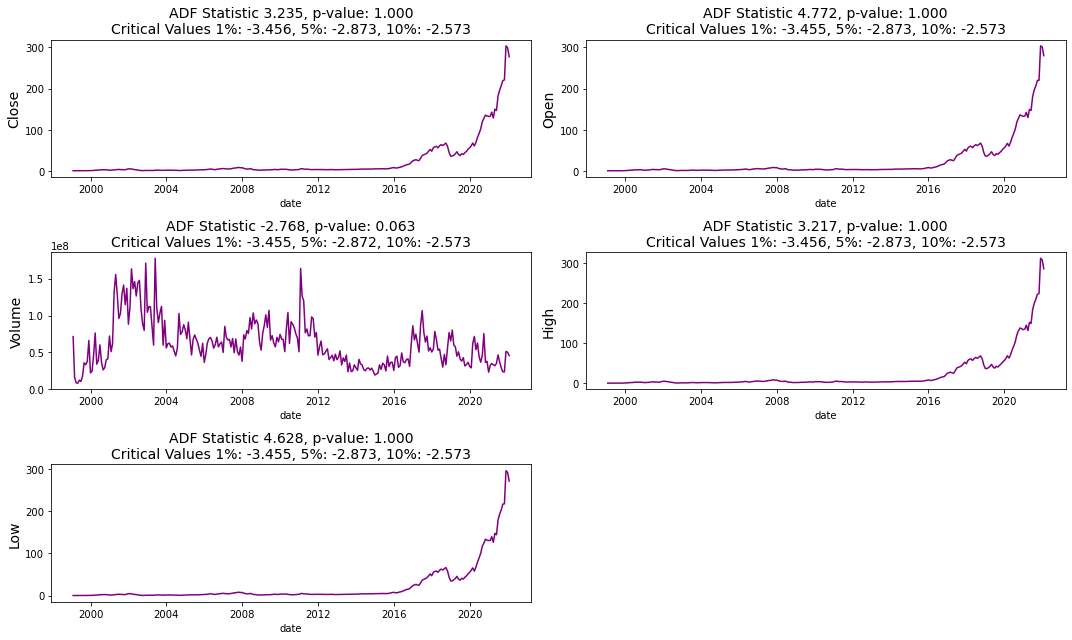

In [18]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['close'].values, 'Close', ax[0, 0])
visualize_adfuller_results(df['volume'].values, 'Volume', ax[1, 0])
visualize_adfuller_results(df['open'].values, 'Open', ax[0, 1])
visualize_adfuller_results(df['high'].values, 'High', ax[1, 1])
visualize_adfuller_results(df['low'].values, 'Low', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()


## Transforming

If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

- **Transformation**: e.g. log or square root to stabilize non-constant variance
- **Differencing**: subtracts the current value from the previous

Reference: https://towardsdatascience.com/how-to-remove-non-stationarity-in-time-series-forecasting-563c05c4bfc7

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='close_log', ylabel='Density'>

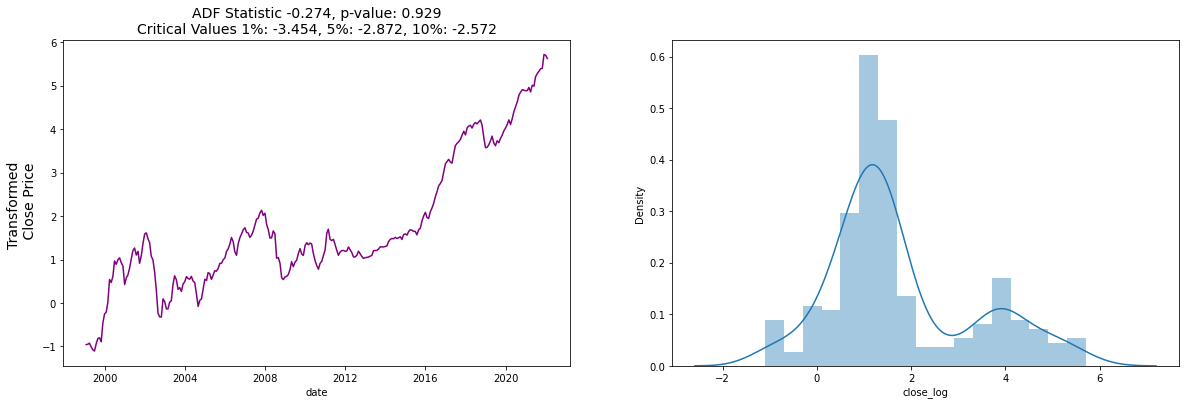

In [19]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['close_log'] = np.log(abs(df['close']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['close_log'], 'Transformed \n Close Price', ax[0])

sns.distplot(df['close_log'], ax=ax[1])

# Still Seems like there is non-stationarity

Differencing cna be done in different orders:
- First order differencing: linear trends with $z_{i} = y_{i} - y_{i-1}$
- Second-order differencing: quadratic trends with $z_{i} = (y_{i} - y_{i-1}) - (y_{i-1} - y_{i-2})$
- and so on...

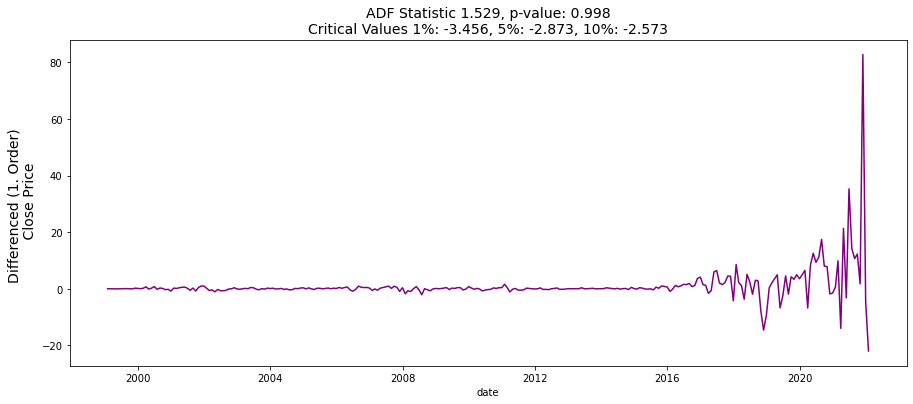

In [20]:
# First Order Differencing
ts_diff = np.diff(df['close'])
df['close_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['close_diff_1'], 'Differenced (1. Order) \n Close Price', ax)
# Still there is stationarity
# Below, we can play around with ordering

Try Second Order Differencing...

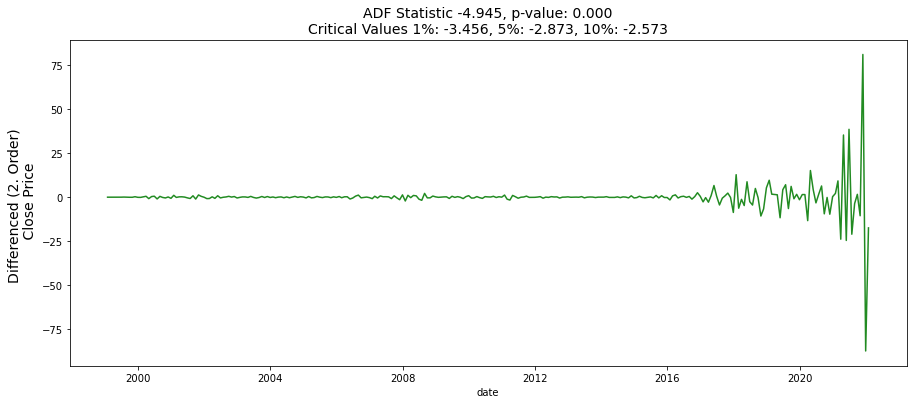

In [21]:
# Second Order Differencing
period = 2
ts_diff = np.diff(df['close'], n = period)
naReplaceLst = [0] * period
df['close_diff_2'] = np.append(naReplaceLst, ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['close_diff_2'], 'Differenced (2. Order) \n Close Price', ax)

Log and First Order/One-Lag Differencing seems to get best result...
Log removes non-linearity

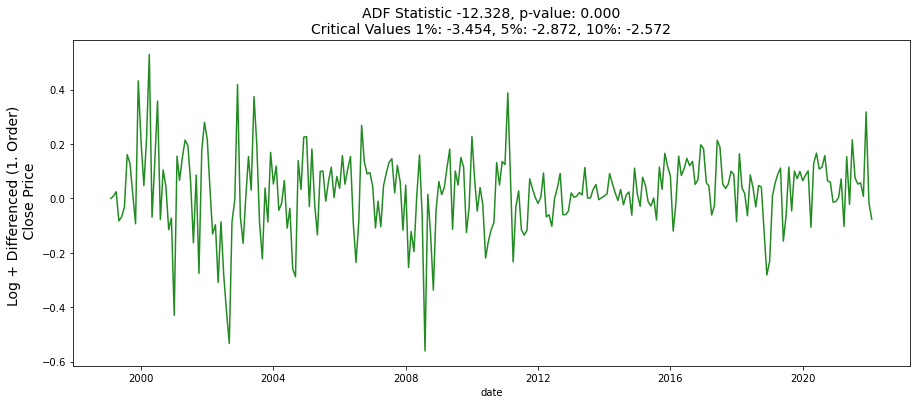

In [22]:
# First order different and logging looks like it gives a good result
period = 1
ts_diff = np.diff(np.log(abs(df['close'])), n = period)
naReplaceLst = [0] * period
df['close_diff_1_log'] = np.append(naReplaceLst, ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['close_diff_1_log'], 'Log + Differenced (1. Order) \n Close Price', ax)

## Feature Engineering

In [23]:
# Add in year, month, day, day of year, week of year, quarter and season column
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['date']).quarter
df['season'] = df['month'] % 12 // 3 + 1
df

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\ipykernel_launcher.py:6: FutureWarning:

weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)



,date,open,high,low,close,volume,dividends,stock_splits,close_log,close_diff_1,close_diff_2,close_diff_1_log,year,month,day,day_of_year,week_of_year,quarter,season
0,1999-01-31,0.396510,0.410265,0.369597,0.384150,7.140480e+07,0.000000,0.0,-0.956723,0.000000,0.000000,0.000000,1999,1,31,31,4,1,1
1,1999-02-28,0.390812,0.404725,0.372619,0.387287,1.656101e+07,0.000000,0.0,-0.948589,0.003137,0.000000,0.008133,1999,2,28,59,8,1,1
2,1999-03-31,0.401008,0.410681,0.386603,0.397004,8.758748e+06,0.000000,0.0,-0.923810,0.009717,0.006579,0.024779,1999,3,31,90,13,1,2
3,1999-04-30,0.369768,0.377514,0.357010,0.365553,8.414400e+06,0.000000,0.0,-1.006343,-0.031450,-0.041167,-0.082533,1999,4,30,120,17,2,2
4,1999-05-31,0.344479,0.352014,0.332697,0.341758,1.241256e+07,0.000000,0.0,-1.073653,-0.023795,0.007655,-0.067310,1999,5,31,151,22,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2021-09-30,219.904501,221.920924,216.692038,219.338858,2.380264e+07,0.000000,0.0,5.390618,12.277118,1.620142,0.057601,2021,9,30,273,39,3,4
273,2021-10-31,219.735476,223.496444,217.488134,221.077217,2.366800e+07,0.000000,0.0,5.398512,1.738358,-10.538760,0.007894,2021,10,31,304,43,4,4
274,2021-11-30,303.681383,311.570893,296.050888,303.848030,5.147493e+07,0.000000,0.0,5.716528,82.770813,81.032455,0.318016,2021,11,30,334,48,4,4
275,2021-12-31,301.231361,307.395454,291.957271,299.307272,5.026108e+07,0.001818,0.0,5.701471,-4.540758,-87.311571,-0.015057,2021,12,31,365,52,4,1


## Encoding Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

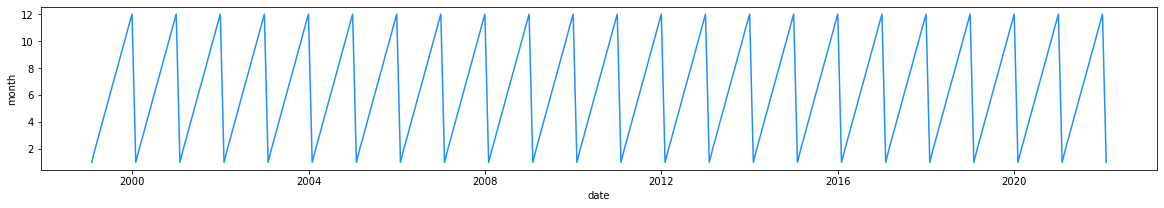

In [24]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
#ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

Encode cyclical feature:

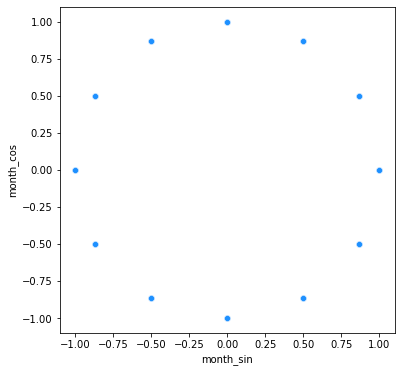

In [25]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.
These components are defined as follows:
- Level: The average value in the series.
- Trend: The increasing or decreasing value in the series.
- Seasonality: The repeating short-term cycle in the series.
- Noise: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
- **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
- **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use function seasonal_decompose() from the statsmodels library.



In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'open', 'high', 'low', 
    'close', 'volume', 'dividends', 'stock_splits'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=12, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

In [27]:
# df.set_index('date', inplace=True) # probably don't need

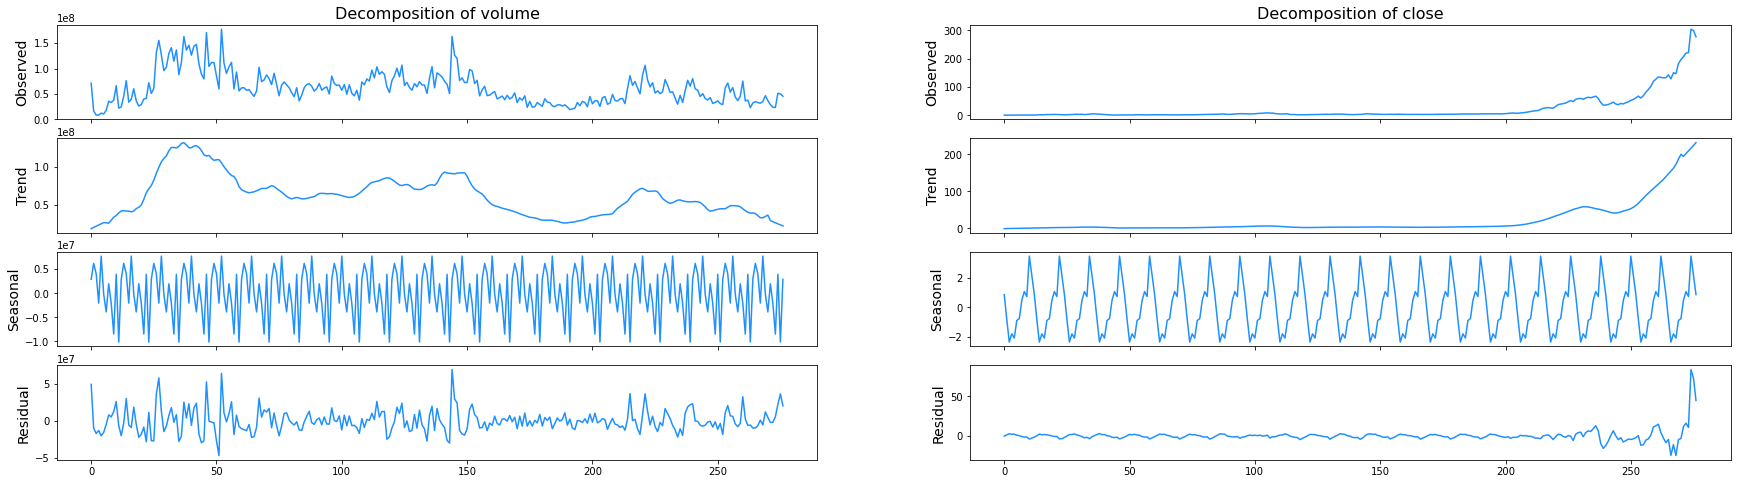

In [28]:
fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(30,8))

for i, column in enumerate(['volume', 'close']):
    
    res = seasonal_decompose(df[column], period=12, model='additive', extrapolate_trend='freq') # freq has been replaced with period

    ax[0,i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0,i], legend=False, color='dodgerblue')
    ax[0,i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1,i], legend=False, color='dodgerblue')
    ax[1,i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2,i], legend=False, color='dodgerblue')
    ax[2,i].set_ylabel('Seasonal', fontsize=14)
    
    res.resid.plot(ax=ax[3,i], legend=False, color='dodgerblue')
    ax[3,i].set_ylabel('Residual', fontsize=14)

plt.show()

In [29]:
df

,date,open,high,low,close,volume,dividends,stock_splits,close_log,close_diff_1,...,low_trend,low_seasonal,close_trend,close_seasonal,volume_trend,volume_seasonal,dividends_trend,dividends_seasonal,stock_splits_trend,stock_splits_seasonal
0,1999-01-31,0.396510,0.410265,0.369597,0.384150,7.140480e+07,0.000000,0.0,-0.956723,0.000000,...,-0.549304,0.796259,-0.583636,0.854403,1.877762e+07,2.899806e+06,0.000000,-0.000209,-0.006710,-0.002169
1,1999-02-28,0.390812,0.404725,0.372619,0.387287,1.656101e+07,0.000000,0.0,-0.948589,0.003137,...,-0.407947,-0.828816,-0.434754,-0.817132,2.034366e+07,6.207493e+06,0.000000,0.000359,-0.005770,-0.001269
2,1999-03-31,0.401008,0.410681,0.386603,0.397004,8.758748e+06,0.000000,0.0,-0.923810,0.009717,...,-0.266591,-2.369829,-0.285873,-2.351057,2.190970e+07,4.064313e+06,0.000000,-0.000120,-0.004830,-0.001310
3,1999-04-30,0.369768,0.377514,0.357010,0.365553,8.414400e+06,0.000000,0.0,-1.006343,-0.031450,...,-0.125234,-1.740982,-0.136991,-1.799084,2.347574e+07,-2.039363e+06,0.000000,-0.000196,-0.003889,0.003226
4,1999-05-31,0.344479,0.352014,0.332697,0.341758,1.241256e+07,0.000000,0.0,-1.073653,-0.023795,...,0.016123,-2.031667,0.011891,-2.081066,2.504178e+07,7.722565e+06,0.000000,0.000220,-0.002949,-0.001392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,2021-09-30,219.904501,221.920924,216.692038,219.338858,2.380264e+07,0.000000,0.0,5.390618,12.277118,...,198.643119,1.089479,202.025774,1.056993,2.783058e+07,-2.084830e+06,0.000641,-0.000125,0.024022,0.001558
273,2021-10-31,219.735476,223.496444,217.488134,221.077217,2.366800e+07,0.000000,0.0,5.398512,1.738358,...,205.967980,0.777690,209.459320,0.723286,2.643282e+07,-8.472954e+06,0.000645,-0.000211,0.025993,-0.001960
274,2021-11-30,303.681383,311.570893,296.050888,303.848030,5.147493e+07,0.000000,0.0,5.716528,82.770813,...,213.292841,3.288283,216.892866,3.451929,2.503506e+07,3.945462e+06,0.000649,0.000305,0.027963,-0.002046
275,2021-12-31,301.231361,307.395454,291.957271,299.307272,5.026108e+07,0.001818,0.0,5.701471,-4.540758,...,220.617702,2.092372,224.326412,2.163093,2.363730e+07,-1.013610e+07,0.000652,-0.000056,0.029933,-0.002131


## Lag
We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.

In [30]:
weeks_in_month = 4

for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3)

# # if data on a weekly basis
# weeks_in_month = 4
# for column in core_columns:
#     df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
#     df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
#     df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
#     df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
#     df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

In [31]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'dividends',
       'stock_splits', 'close_log', 'close_diff_1', 'close_diff_2',
       'close_diff_1_log', 'year', 'month', 'day', 'day_of_year',
       'week_of_year', 'quarter', 'season', 'month_sin', 'month_cos',
       'open_trend', 'open_seasonal', 'high_trend', 'high_seasonal',
       'low_trend', 'low_seasonal', 'close_trend', 'close_seasonal',
       'volume_trend', 'volume_seasonal', 'dividends_trend',
       'dividends_seasonal', 'stock_splits_trend', 'stock_splits_seasonal',
       'open_seasonal_shift_b_2m', 'open_seasonal_shift_b_1m',
       'open_seasonal_shift_1m', 'open_seasonal_shift_2m',
       'open_seasonal_shift_3m', 'high_seasonal_shift_b_2m',
       'high_seasonal_shift_b_1m', 'high_seasonal_shift_1m',
       'high_seasonal_shift_2m', 'high_seasonal_shift_3m',
       'low_seasonal_shift_b_2m', 'low_seasonal_shift_b_1m',
       'low_seasonal_shift_1m', 'low_seasonal_shift_2m',
       'low_seasonal_shift_3m'

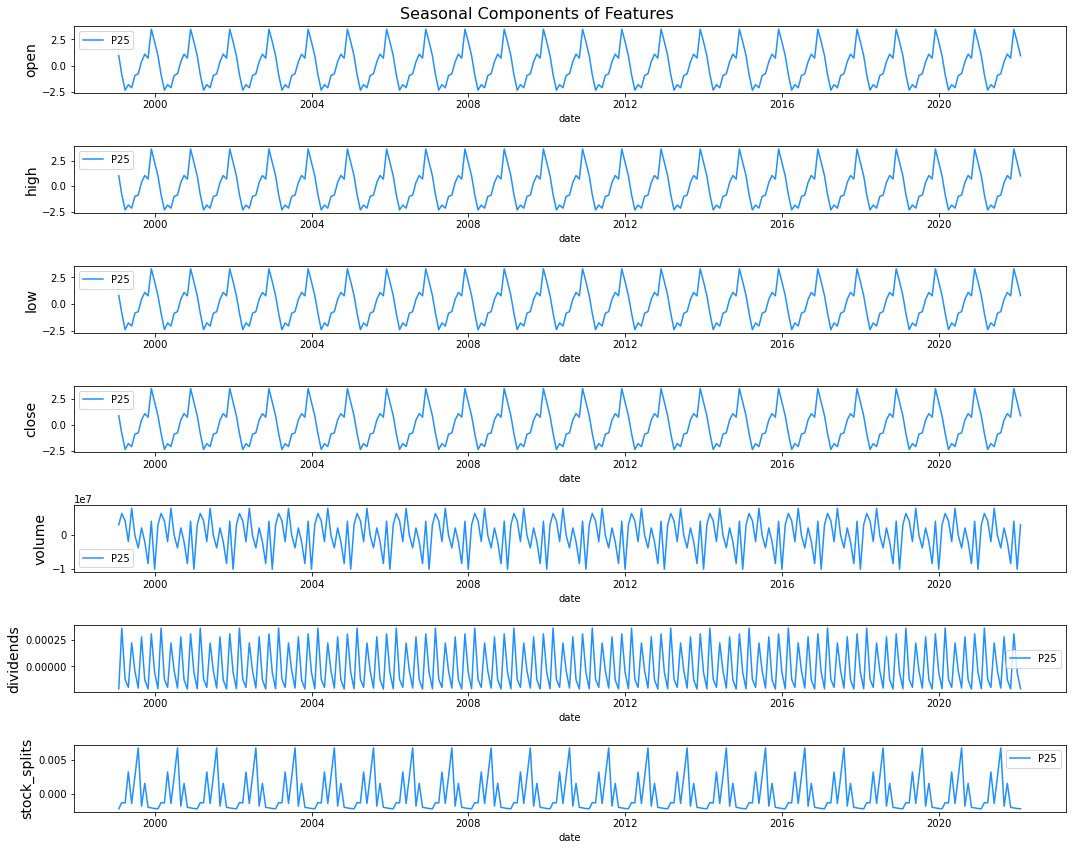

In [32]:
f, ax = plt.subplots(nrows=7, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    #ax[i].set_xlim([date(2016, 9, 30), date(2022, 1, 1)])
    
plt.tight_layout()
plt.show()

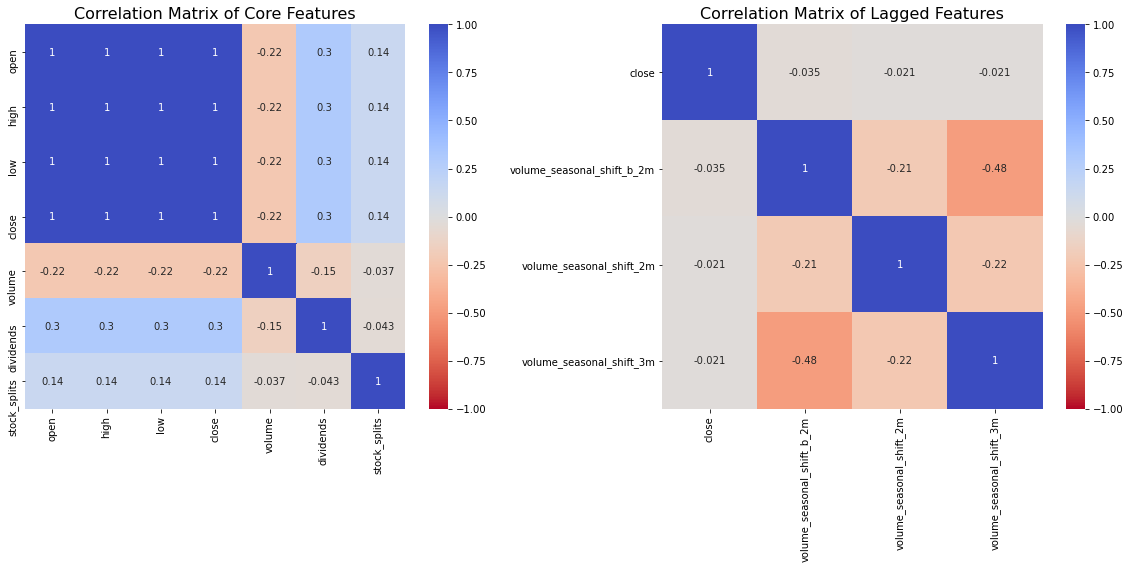

In [33]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)

shifted_cols = [
    'close',         
    'volume_seasonal_shift_b_2m',
    'volume_seasonal_shift_2m', 
    'volume_seasonal_shift_3m'
]
corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)


plt.tight_layout()
plt.show()

## Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.
- **Autocorrelation Function (ACF) [MA Modle]**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
- **Partial Autocorrelation Function (PACF) [AR Model]**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

(0.0, 50.0)

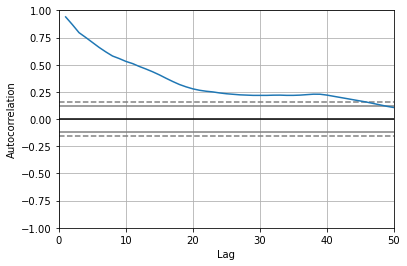

In [184]:
from pandas.plotting import autocorrelation_plot

ax = autocorrelation_plot(df['close'])
ax.set_xlim([0, 50])

# First 12 lags are probably of importances, greater than 0.50, so p = 12



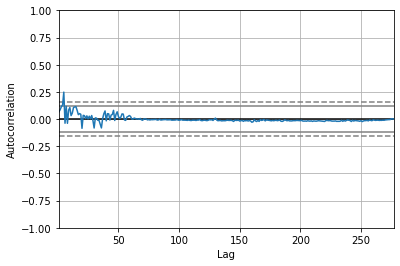

In [34]:
# Autocorrelation plots help in detecting seasonality.
autocorrelation_plot(df['close_diff_1'])
plt.show()

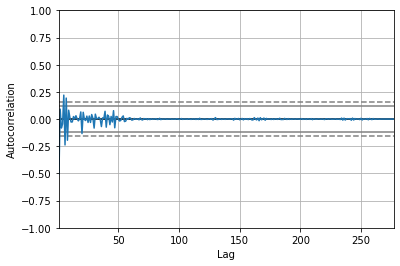

In [35]:
# Autocorrelation plots help in detecting seasonality.
autocorrelation_plot(df['close_diff_2'])
plt.show()

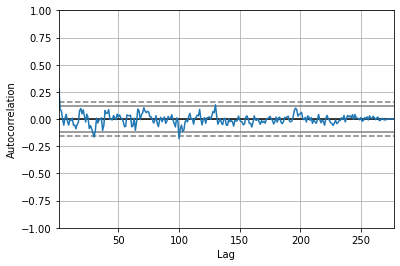

In [36]:
# Autocorrelation plots help in detecting seasonality.
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['close_diff_1_log'])
plt.show()

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



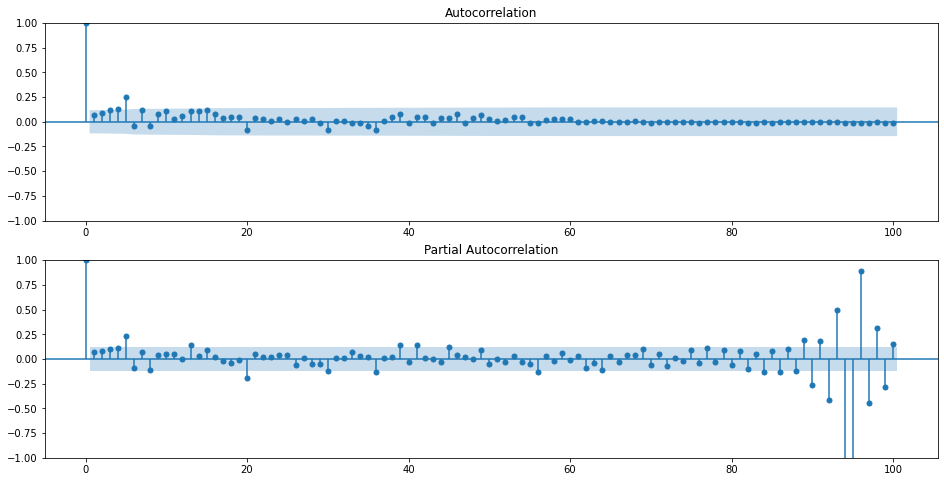

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['close_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['close_diff_1'], lags=100, ax=ax[1])

plt.show()

# Here it looks like it's based on decaying ACF, we are likely dealing with an auto regressive process...

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



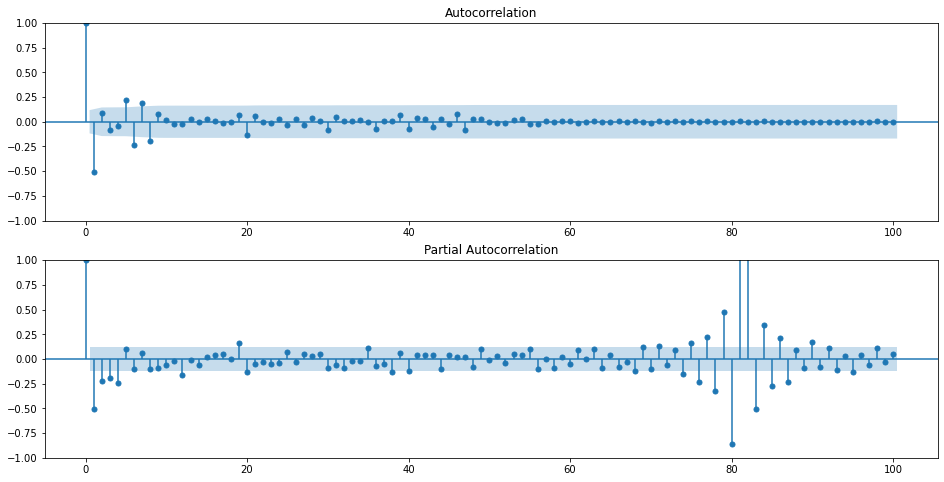

In [38]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['close_diff_2'], lags=100, ax=ax[0])
plot_pacf(df['close_diff_2'], lags=100, ax=ax[1])

plt.show()

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



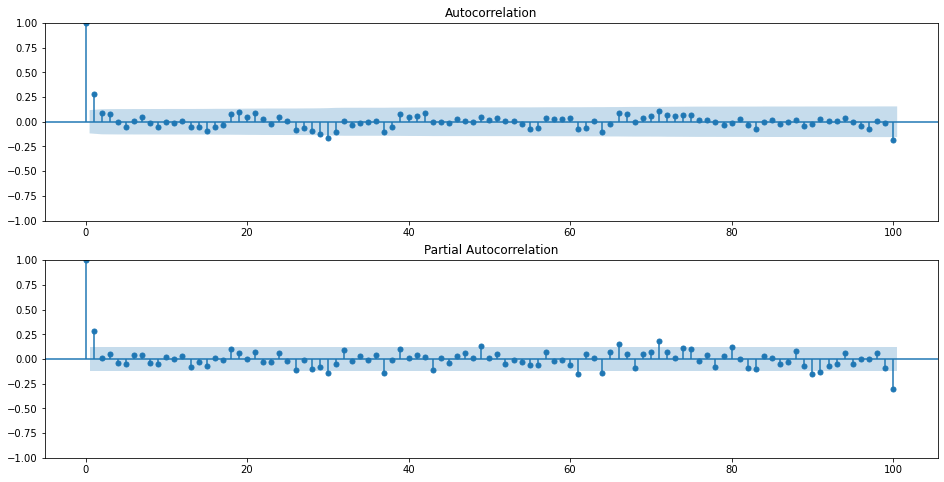

In [39]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['close_diff_1_log'], lags=100, ax=ax[0])
plot_pacf(df['close_diff_1_log'], lags=100, ax=ax[1])

plt.show()

From current understanding, it's best to have the least number of variables in our models. Both Autocorrelation and Partial Autocorrelation seem to have the same number of variables. We will use a second AR(2) model.

Based on PACF, we should start with an auto regressive model with lags 1,2, 100

# Modeling :)
Time series can be either univariate or multivariate:

- **Univariate** time series only has a single time-dependent variable.
- **Multivariate** time series have a multiple time-dependent variable.

But, first of all we are going to see how does cross-validation technique works in TimeSeries Analysis.



In [40]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['close']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

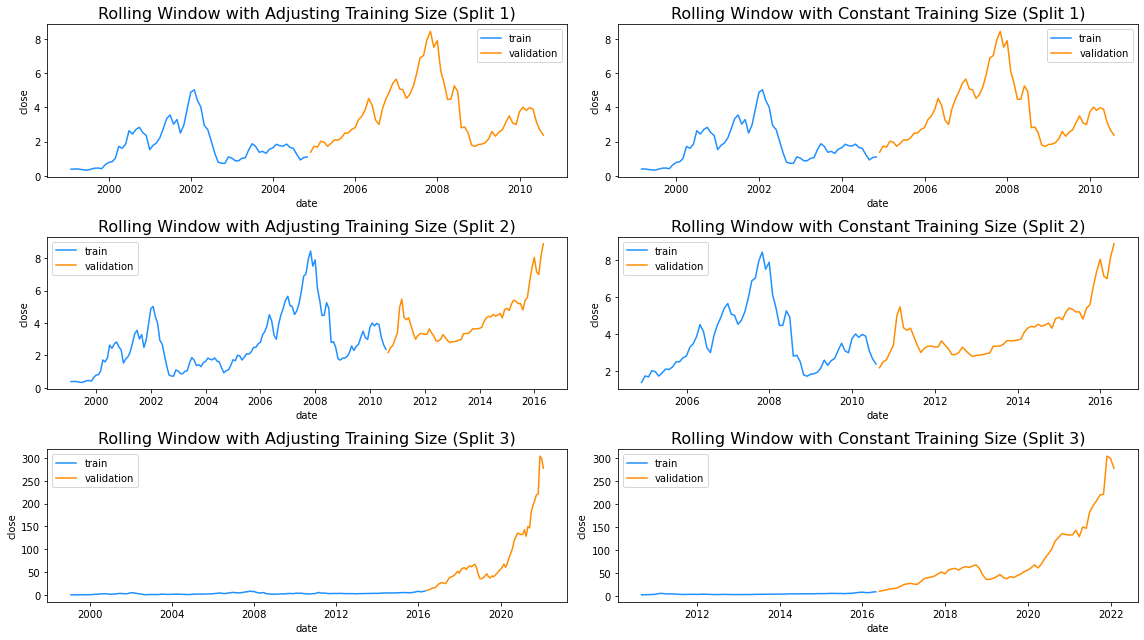

In [41]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        y=y_train[len(X_train) - len(X_valid):(len(X_train) - len(X_valid) + len(X_valid))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_valid, y= y_valid, ax=ax[i, j], color='darkorange', label='validation')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

# for i in range(N_SPLITS):
#     ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
#     ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.




## Models for Univariate Time Series

First of all, we are going to analize univariate TimeSeries forecasting.

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [172]:
train_size = int(0.85 * len(df)) # Split Data
test_size = len(df) - train_size

univariate_df = df[['date', 'close']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

235 42


### Facebook Prophet Model 
The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.
Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.
Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [173]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from fbprophet import Prophet


# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

# print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print('RMSE: {}'.format(score_rmse))

RMSE: 76.605150382311


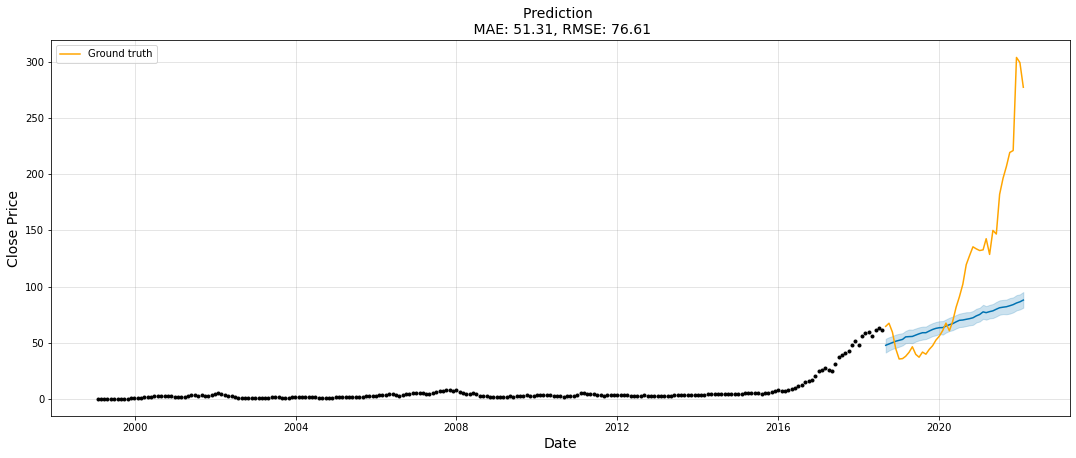

In [174]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close Price', fontsize=14)

plt.show()

### ARIMA
The Auto-Regressive Integrated Moving Average (ARIMA) model describes the **autocorrelations** in the data. The model assumes that the time-series is **stationary**. It consists of three main parts:
- Auto-Regressive (AR) filter (long term): $y_{t} = c+{\alpha}y_{t-1}+...{\alpha}_{p}y_{t-p}+{\epsilon}_{t} = c + \sum \limits _{i=1} ^{p}{\alpha}_{t-i}+{\epsilon}_{t} \rightarrow p$
- Integration Filter (Stochastic Trend): -> $d$
- Moving Average (MA) filter (short term): $y_{t} = c+{\epsilon}_{t} + {\beta}_{1}{\epsilon}_{t-1}+...+ {\beta}_{q}{\epsilon}_{t-q} = c+{\epsilon}_{t}+\sum \limits _{i=1} ^{q}{\beta}_{i}{\epsilon}_{t-i} \rightarrow q$

**ARIMA**: $y_{t} = c+{\alpha}y_{t-1}+...+{\alpha}_{p}y_{t-p}+{\epsilon}_{t} + {\beta}_{1}{\epsilon}_{t-1}+...+{\beta}_{q}{\epsilon}_{t-q}$

ARIMA(p,d,q)
- p: Lag Order (reference PACF in Autocorrelation Analysis)
- d: Degree of differencing (reference Differencing in Stationarity)
- q: Order of moving average (check out ACF in Autocorrelation)

Steps to analyze ARIMA
- **Step 1 - Check Stationarity:** If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.
- **Step 2 - Difference:** If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
- **Step 3 - Filter out a validation sample:** This will be used to validate how accurate our model is. Use train test validation split to achieve this
- **Step 4 - Select AR and MA Terms:** Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
- **Step 5 - Build the model:**  Build the model and set the number of periods to forecast to N (depends on your needs).
- **Step 6 - Validate Model:** Compare the predicted values to the actuals in the validation sample.

In [214]:
from statsmodels.tsa.arima.model import ARIMA

# Fit model
model = ARIMA(y_train, order=(4,2,1)) # Used 4,2,1 from auto arima. Otherwise, used 12,1,0. 12 is obtained from an above step
model_fit = model.fit()
model_fit.summary()

# Prediction with ARIMA
y_pred = model_fit.forecast(42) # Why can't I forecast more than 42 out?
# y_pred, se, conf = model_fit.forecast(90) # Not working

# Calcuate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print('RMSE: {}'.format(score_rmse))

RMSE: 60.703193191040576


In [215]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  235
Model:                 ARIMA(4, 2, 1)   Log Likelihood                -347.475
Date:                Wed, 19 Jan 2022   AIC                            706.949
Time:                        14:20:46   BIC                            727.655
Sample:                             0   HQIC                           715.299
                                - 235                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0885      0.039     -2.258      0.024      -0.165      -0.012
ar.L2         -0.1884      0.050     -3.738      0.000      -0.287      -0.090
ar.L3         -0.1054      0.043     -2.438      0.015      -0.190      -0.021
ar.L4          0.2457      0.040      6.213      0.000       0.168       0.323
ma.L1         -0.8643      0.023    -37.097      0.000      -0.910      -0.819
sigma2         1.1455      0.049     23.372      0.000       1.049       1.242
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1950.30
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              14.61   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
start=len(y_train)
end=len(y_train)+len(y_valid)-1
predictions = model_fit.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA Predictions')

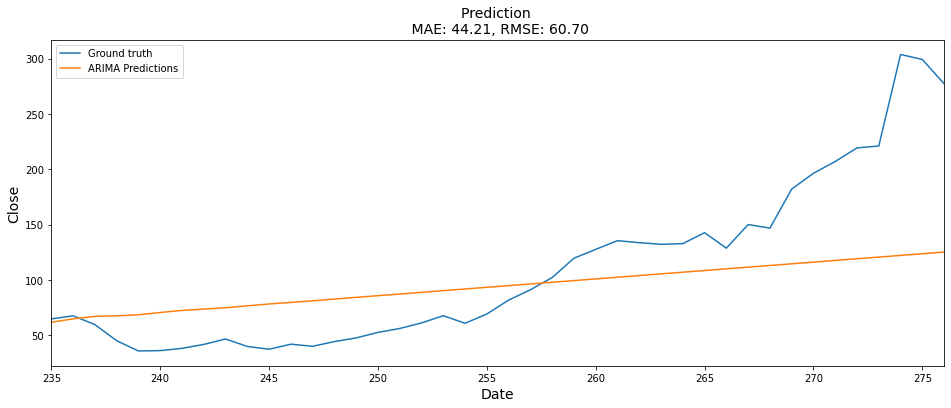

In [217]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)
ax = y_valid['y'].plot(legend=True,figsize=(16,6),title="actual vs predictions", label='Ground truth')
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Close', fontsize=14)

#ax.set_ylim(-35, -18)
plt.show()

In [218]:
# Broken Code due to model_fit.plot_predict not working!!!!!!!!!!!!
# f, ax = plt.subplots(1)
# f.set_figheight(6)
# f.set_figwidth(15)

# #model_fit.plot_predict(1, 599, ax=ax)
# sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

# ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
# ax.set_xlabel(xlabel='Date', fontsize=14)
# ax.set_ylabel(ylabel='Close', fontsize=14)

# ax.set_ylim(-35, -18)
# plt.show()

In [219]:
# Train with entire dataset and patch so that date shows up in plots
univariate_arima_df = univariate_df.copy(deep = True)
univariate_arima_df.set_index(['ds'], inplace = True)
model = ARIMA(univariate_arima_df['y'],order=(1,1,1))
results = model.fit()
forecast_values = results.predict(len(univariate_arima_df['y']),len(univariate_arima_df['y'])+12-1,typ='levels').rename('ARIMA Forecast')

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning:

No frequency information was provided, so inferred frequency M will be used.

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\malikf1\Anaconda3\envs\python_3_7\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



[Text(0.5, 0, ' '), Text(0, 0.5, 'forecast value')]

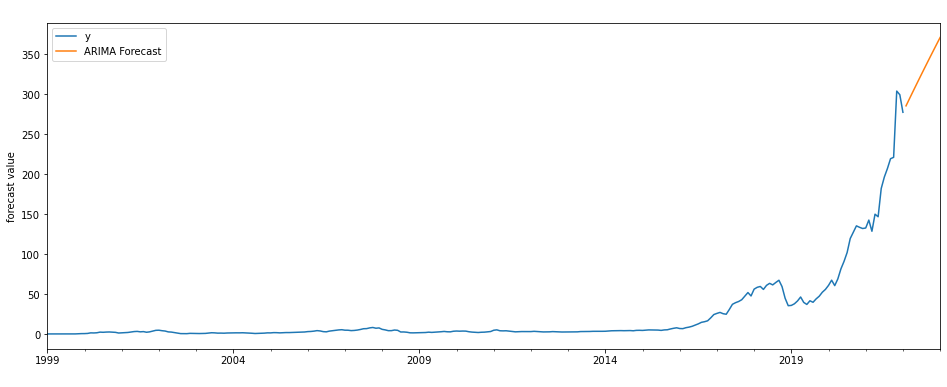

In [220]:
ax = univariate_arima_df['y'].plot(legend=True,figsize=(16,6),title=" ")
forecast_values.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=" ", ylabel="forecast value")
#ax.set_xticks([0,200,400,800,1000])

### Auto-ARIMA

In [209]:
!pip install pmdarima

In [212]:
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=6, max_q=6, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
# Go back and use 4,2,1

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=725.743, Time=0.07 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=868.614, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=821.568, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=724.645, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=724.923, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=720.921, Time=0.20 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=716.337, Time=0.18 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=717.479, Time=0.15 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=709.553, Time=0.16 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=711.264, Time=0.12 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=708.708, Time=0.25 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=706.949, Time=0.16 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=719.882, Time=0.11 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=708.254, Time=0.22 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=721.9

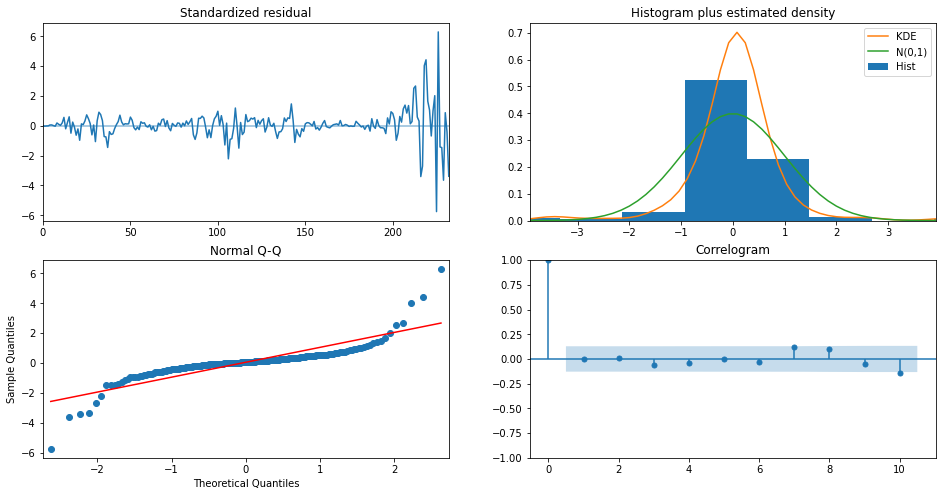

In [213]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

- **Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

- **Top Right:** The density plot suggest normal distribution with mean zero.

- **Bottom left:** The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

- **Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

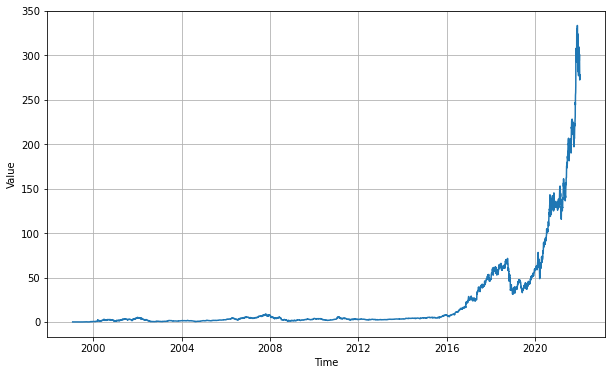

In [21]:
# dump['NVDA'] = dump['NVDA'].dropna()
# dump['NVDA'].reset_index(inplace=True, drop = True)
time = dump[myTicker].index.values #np.arange(len(dump['NVDA']), dtype="float32")
time = dump[myTicker]['date']
series = dump[myTicker]['close'].to_numpy()

plt.figure(figsize=(10, 6))
plot_series(time, series, start = None)

In [18]:
stockPriceViz = go.Scatter(x=stockDataFrame['date'], y=stockDataFrame['close'])
layout = go.Layout(title= myTicker, xaxis=dict(title='Date'), yaxis=dict(title='Price ($)'))
fig = go.Figure(data=[stockPriceViz], layout=layout)
iplot(fig)

## Split Data and Configure Window, Batch, and Shuffle Size

In [ ]:
# Train/Test Split
split_time = int(len(series)*0.70) # 4000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Single Layer Dense Neural Network

In [ ]:
# https://keras.io/guides/sequential_model/
# Only for DNN
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # Create a dataset from the series
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # slice data up into appropriate windows, each shifted by one time stamp
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # flatten data out to make easier to work iwth. This will be flattened into chunks of window size. Basically make it into an array
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1])) # Shuffle buffer speeds things up. 
  # Buffer Extra information: 100,000 items in dataset, set buffer to a 1000, it will just fill buffer with first 1000 elements and pick them at random. Then it will fill the second buffer with the second 1000 random elements. 
  # Then window so you have x's and y's separate
  dataset = dataset.batch(batch_size).prefetch(1) # here, the data is batched (given set of x's and y's based on batch_size)
  return dataset
# dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# for x,y in dataset:
#    print(x.numpy(), y.numpy())


In [ ]:
# Only for DNN
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size]) # Single layer
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=50,verbose=1)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/50
67/67 [==============================] - 0s 4ms/step - loss: 18.3652
Epoch 2/50
67/67 [==============================] - 0s 3ms/step - loss: 9.8911
Epoch 3/50
67/67 [==============================] - 0s 3ms/step - loss: 5.3272
Epoch 4/50
67/67 [==============================] - 0s 3ms/step - loss: 2.9252
Epoch 5/50
67/67 [==============================] - 0s 3ms/step - loss: 1.6656
Epoch 6/50
67/67 [==============================] - 0s 3ms/step - loss: 1.0021
Epoch 7/50
67/67 [==============================] - 0s 3ms/step - loss: 0.6533
Epoch 8/50
67/67 [==============================] - 0s 3ms/step - loss: 0.4701
Epoch 9/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3736
Epoch 10/50
67/67 [==============================] - 0s 2ms/step - loss: 0.3229
Epoch 11/50
67/67 [==============================] - 0s 2ms/step - loss: 0.2961
Epoch 12/50
67/67 [==========================

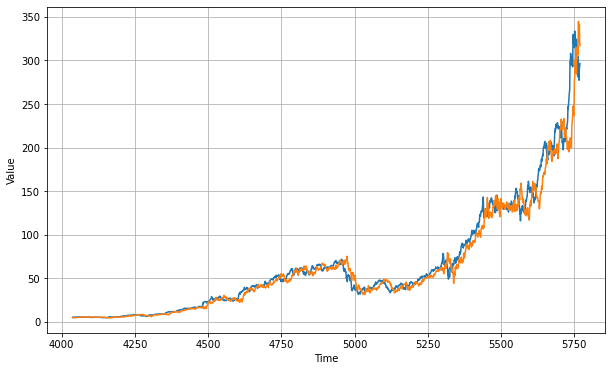

In [ ]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.6209755

## Deep Dense Neural Networks (Multi-Layer)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), # 10 neurons with relu activation function (first layer)
    tf.keras.layers.Dense(10, activation="relu"), # 10 neurons with relu activation function (second layer)
    tf.keras.layers.Dense(1) # 1 output?
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=1)
model.summary()


Epoch 1/100
67/67 [==============================] - 1s 3ms/step - loss: 4.5722
Epoch 2/100
67/67 [==============================] - 0s 3ms/step - loss: 3.8693
Epoch 3/100
67/67 [==============================] - 0s 3ms/step - loss: 3.2375
Epoch 4/100
67/67 [==============================] - 0s 3ms/step - loss: 2.6854
Epoch 5/100
67/67 [==============================] - 0s 3ms/step - loss: 2.2087
Epoch 6/100
67/67 [==============================] - 0s 3ms/step - loss: 1.8024
Epoch 7/100
67/67 [==============================] - 0s 3ms/step - loss: 1.4617
Epoch 8/100
67/67 [==============================] - 0s 3ms/step - loss: 1.1792
Epoch 9/100
67/67 [==============================] - 0s 3ms/step - loss: 0.9483
Epoch 10/100
67/67 [==============================] - 0s 3ms/step - loss: 0.7617
Epoch 11/100
67/67 [==============================] - 0s 3ms/step - loss: 0.6116
Epoch 12/100
67/67 [==============================] - 0s 3ms/step - loss: 0.4928
Epoch 13/100
67/67 [=================

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0] # Formatting thing


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

KeyboardInterrupt: 

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.399183

In [ ]:
# Learning Rate Schedule
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
125/125 [==============================] - 1s 3ms/step - loss: 4.4479 - lr: 1.0000e-08
Epoch 2/100
125/125 [==============================] - 0s 2ms/step - loss: 4.4089 - lr: 1.1220e-08
Epoch 3/100
125/125 [==============================] - 0s 2ms/step - loss: 4.3651 - lr: 1.2589e-08
Epoch 4/100
125/125 [==============================] - 0s 2ms/step - loss: 4.3162 - lr: 1.4125e-08
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 4.2615 - lr: 1.5849e-08
Epoch 6/100
125/125 [==============================] - 0s 2ms/step - loss: 4.2006 - lr: 1.7783e-08
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 4.1325 - lr: 1.9953e-08
Epoch 8/100
125/125 [==============================] - 0s 2ms/step - loss: 4.0563 - lr: 2.2387e-08
Epoch 9/100
125/125 [==============================] - 0s 2ms/step - loss: 3.9710 - lr: 2.5119e-08
Epoch 10/100
125/125 [==============================] - 0s 2ms/step - loss: 3.8755 - lr: 2.8184e-08
Epoch 11/

(1e-05, 0.001, 0.0, 0.2)

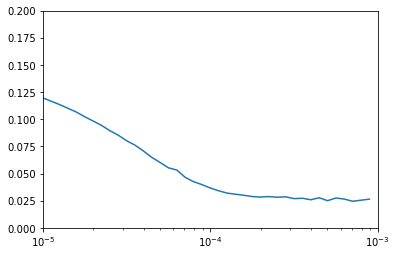

In [ ]:
# loss vs learning rate
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-5, 1e-3, 0, 0.2])

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
window_size = 30
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=0)

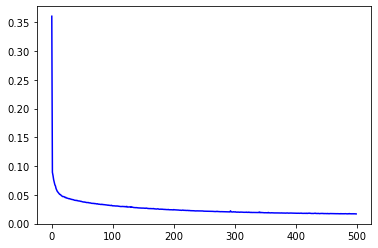

In [ ]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

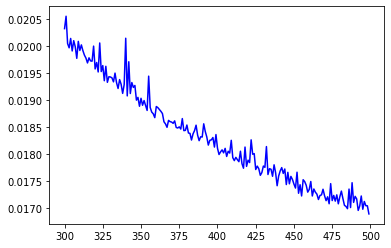

In [ ]:
# Plot all but the first 10
loss = history.history['loss']
epochs = range(300, len(loss))
plot_loss = loss[300:]
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

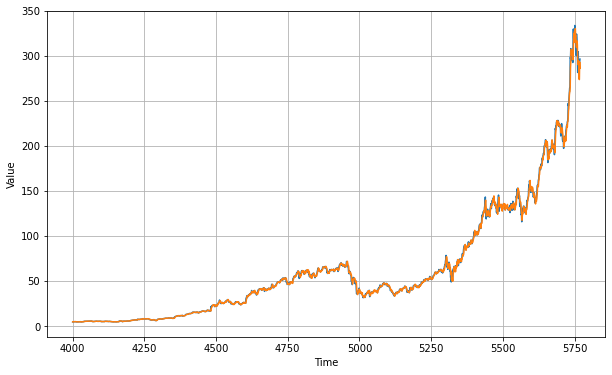

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

1.5019423

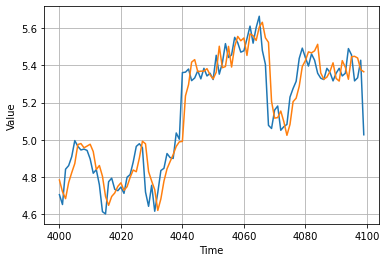

In [ ]:

plot_series(time_valid, x_valid, end = 100)
plot_series(time_valid, results, end = 100)

In [ ]:
len(series[4000:])

1770

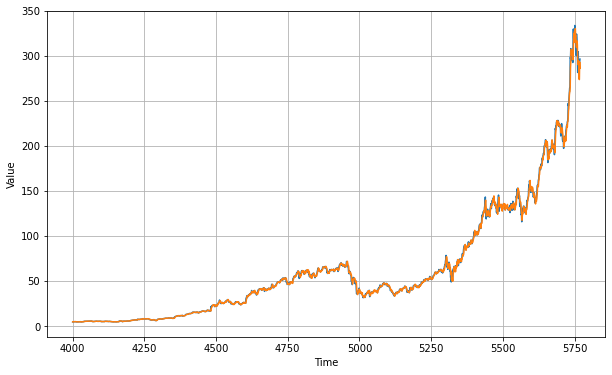

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

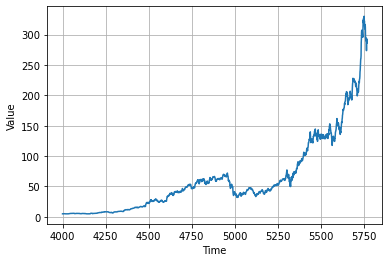

In [ ]:
plot_series(time_valid, results)

In [ ]:
len(results)

1740

In [ ]:
len(time_valid)

1770